# Testing and using watershed algorithm in congestion with devolearn 

In [1]:
import sys
from pathlib import Path
# sys.path.append('../')
sys.path.append('/home/hrc/gsoc/d-gnn/devolearn')

import os
import cv2 
import numpy as np
from matplotlib import pyplot as plt

FILE_PATH = '/home/hrc/Downloads/GSoC/dataset/'

In [2]:
import re

# Define the paths to the folders
features_folder = "/home/hrc/Downloads/GSoC/dataset/features/features"
segmentation_folder = "/home/hrc/Downloads/GSoC/dataset/segmentation_maps_1"

# Get a list of filenames in each folder
features_filenames = os.listdir(features_folder)
segmentation_filenames = os.listdir(segmentation_folder)

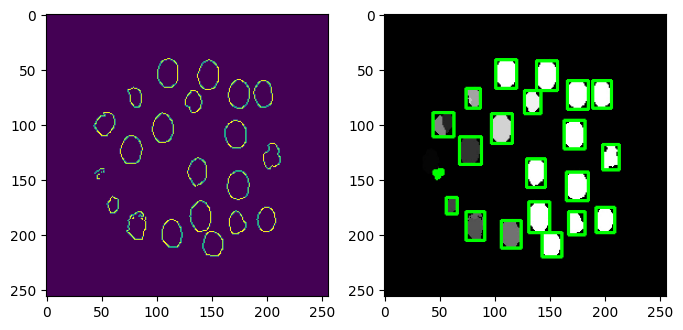

25


In [18]:
image = cv2.imread('/home/hrc/Downloads/GSoC/dataset/segmentation_maps_1/L72_16.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 20, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(binary_image,100,200)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    boxes.append([x, y, w, h])
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draws a green rectangle

# Save the image with bounding boxes (optional)
cv2.imwrite('cell_masks_with_bboxes.png', image)

fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(edges)

fig.add_subplot(rows, columns, 2)
plt.imshow(image)

plt.show()

print(len(boxes))

In [9]:
import devolearn

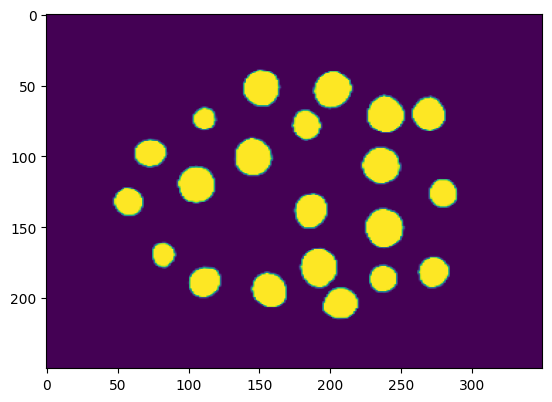

[[3.9522792e-08 2.5401244e-08 1.2753378e-08 ... 1.0395535e-07
  2.1053323e-07 3.3015328e-07]
 [8.4240748e-09 5.3404152e-09 2.6034266e-09 ... 3.3162276e-08
  8.5951136e-08 1.4924544e-07]
 [1.7948796e-09 1.1227189e-09 5.3134891e-10 ... 1.0683652e-08
  3.5775631e-08 6.7454415e-08]
 ...
 [9.6194860e-08 5.0582166e-08 1.4642088e-08 ... 6.8490894e-11
  1.5324531e-10 2.5115263e-10]
 [2.7387097e-07 1.5004892e-07 4.9968307e-08 ... 2.4916055e-10
  5.2595117e-10 8.4046753e-10]
 [7.7952774e-07 4.4735563e-07 1.7091378e-07 ... 9.0674923e-10
  1.8067479e-09 2.8117442e-09]]


True

In [10]:
from devolearn import cell_nucleus_segmentor
segmentor = cell_nucleus_segmentor()

seg_pred = segmentor.predict(image_path = "/home/hrc/Downloads/GSoC/dataset/features/features/F72_16.png")
plt.imshow(seg_pred)
plt.show()

type(seg_pred)

print(seg_pred)

cv2.imwrite('seg_img.png', 255*seg_pred)
# cv2.imshow("image", seg_pred)
# cv2.waitKey()

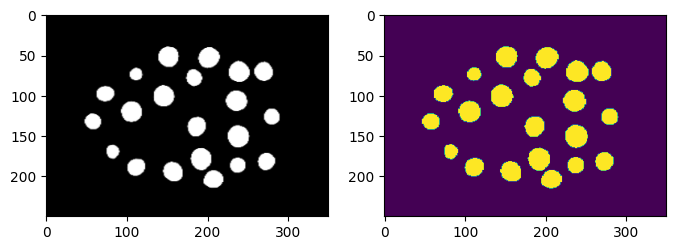

In [11]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv2.imread('seg_img.png')
# img = seg_pred
orig_img = img.copy()
assert img is not None, "file could not be read, check with os.path.exists()"
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# plt.imshow(gray)
# ret, thresh = cv.threshold(gray,125,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
# plt.imshow(thresh)
ret,thresh = cv2.threshold(gray,10,255,0)

fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(img)

fig.add_subplot(rows, columns, 2)
plt.imshow(thresh)

plt.show()

13.370026


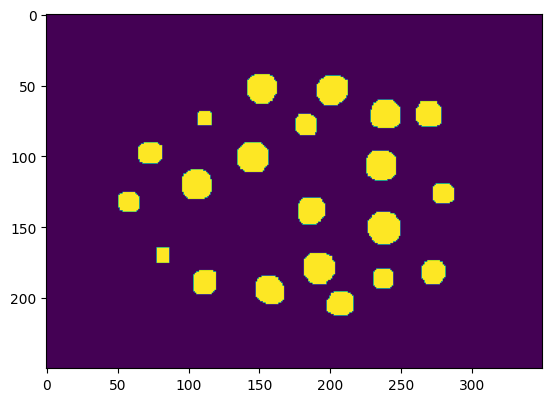

In [14]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 5)

# sure background area

sure_bg = cv.dilate(opening,kernel,iterations=7)

# Finding sure foreground area

dist_transform = cv.distanceTransform(opening,cv.DIST_L2,3)
ret, sure_fg = cv.threshold(dist_transform,0.2*dist_transform.max(),255,cv.THRESH_BINARY)

print(dist_transform.max())
# Finding unknown region

sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg,sure_fg)

plt.imshow(sure_fg)

In [15]:
# Marker labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0


In [16]:
markers = cv.watershed(img,markers)
img[markers == -1] = [255,0,0]

In [71]:
# fig, ax = plt.subplots(figsize=(6, 6)) 
# ax.imshow(markers, cmap="tab20b") 
# ax.axis('off') 
# plt.show()

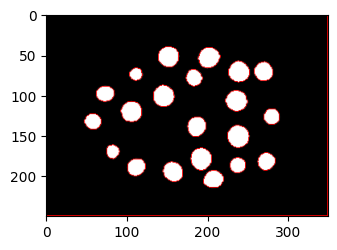

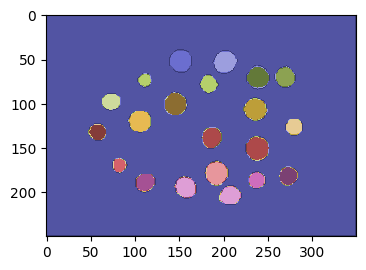

In [20]:
fig = plt.figure(figsize=(8, 8))
columns = 1
rows = 1

# fig.add_subplot(rows, columns, 1)
# plt.imshow(orig_img)

fig.add_subplot(rows, columns, 2)
plt.imshow(img)

fig, ax = plt.subplots(figsize=(4, 4)) 
ax.imshow(markers, cmap="tab20b") 
plt.show()

## Different method not good results

In [17]:
# import the necessary packages
from skimage.feature import peak_local_max
# from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import argparse
import imutils
import cv2

In [ ]:
# loop over the unique labels returned by the Watershed
# algorithm
for marker in np.unique(markers):
    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if marker == 0:
        continue
    # otherwise, allocate memory for the label region and draw
    # it on the mask
    mask = np.zeros(thresh.shape, dtype="uint8")
    mask[markers == marker] = 255
    # detect contours in the mask and grab the largest one
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # draw a circle enclosing the object
    ((x, y), r) = cv2.minEnclosingCircle(c)
    cv2.circle(orig_img, (int(x), int(y)), int(r), (0, 255, 0), 2)
    cv2.putText(orig_img, "#{}".format(mask), (int(x) - 10, int(y)),
        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
# show the output image
cv2.imshow("Output", orig_img)
cv2.waitKey(0)

QObject::moveToThread: Current thread (0x783d1b0) is not the object's thread (0x6cdaf40).
Cannot move to target thread (0x783d1b0)

QObject::moveToThread: Current thread (0x783d1b0) is not the object's thread (0x6cdaf40).
Cannot move to target thread (0x783d1b0)

QObject::moveToThread: Current thread (0x783d1b0) is not the object's thread (0x6cdaf40).
Cannot move to target thread (0x783d1b0)

QObject::moveToThread: Current thread (0x783d1b0) is not the object's thread (0x6cdaf40).
Cannot move to target thread (0x783d1b0)

QObject::moveToThread: Current thread (0x783d1b0) is not the object's thread (0x6cdaf40).
Cannot move to target thread (0x783d1b0)

QObject::moveToThread: Current thread (0x783d1b0) is not the object's thread (0x6cdaf40).
Cannot move to target thread (0x783d1b0)

QObject::moveToThread: Current thread (0x783d1b0) is not the object's thread (0x6cdaf40).
Cannot move to target thread (0x783d1b0)

QObject::moveToThread: Current thread (0x783d1b0) is not the object's thread